In [1]:
from scipy.stats import spearmanr, pearsonr

from bertscore import BERTScore
from conventional_metrics import BLEU, METEOR
from scm import SCM, ContextualSCM
from wmd import WMD, ContextualWMD
from common import Evaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Mutual correlations of metrics

In [2]:
from pathlib import Path

if not (Path('embeddings')/'cc.en.300.bin').exists():
    %mkdir -p embeddings
    ! wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -O embeddings/cc.en.300.bin.gz
    ! gzip -d embeddings/cc.en.300.bin.gz

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xnovot32/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/xnovot32/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of the model ch

Evaluating lang pair cs-en


METEOR: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:03<00:00, 169.72it/s]
BERTScore: 18it [00:07,  2.27it/s]                                                                                                                                                                                
WMD: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:01<00:00, 307.13it/s]


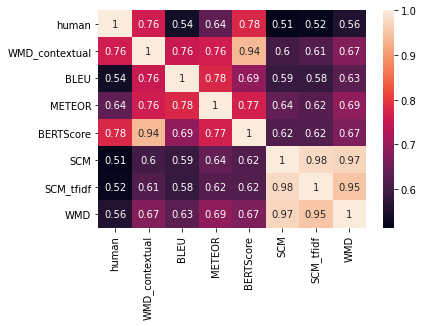

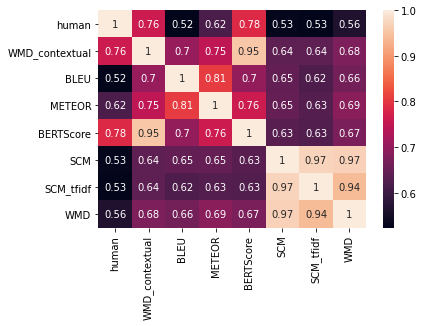

Evaluating lang pair de-en


METEOR: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:00<00:00, 870.90it/s]
BERTScore: 18it [00:07,  2.31it/s]                                                                                                                                                                                
WMD: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:01<00:00, 361.11it/s]


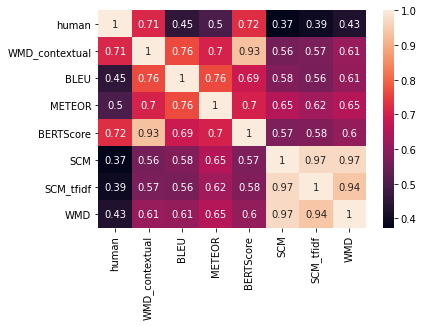

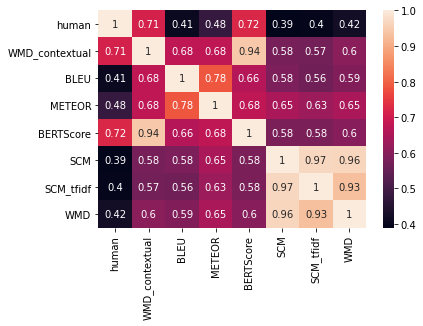

Evaluating lang pair fi-en


METEOR: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:00<00:00, 578.26it/s]
BERTScore: 18it [00:10,  1.76it/s]                                                                                                                                                                                
WMD: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:02<00:00, 203.50it/s]


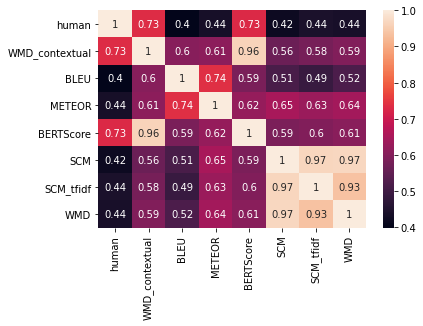

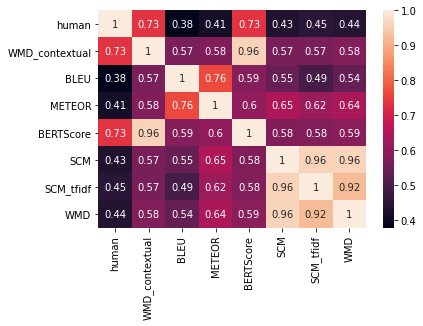

Evaluating lang pair ru-en


METEOR: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:00<00:00, 833.90it/s]
BERTScore: 18it [00:09,  1.88it/s]                                                                                                                                                                                
WMD: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:02<00:00, 210.71it/s]


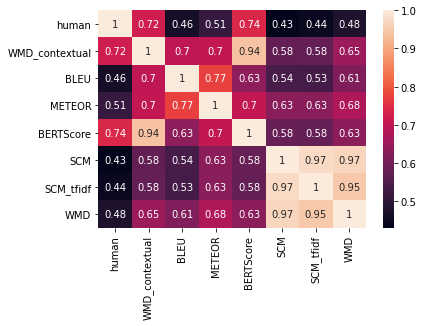

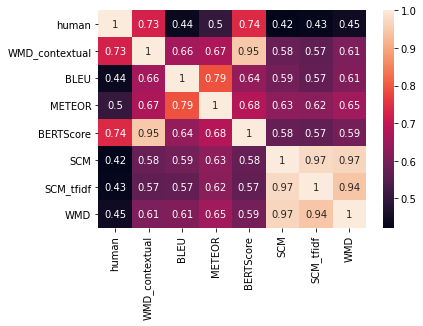

CPU times: user 10h 46min 27s, sys: 19h 20min 2s, total: 1d 6h 6min 29s
Wall time: 33min 50s


In [3]:
%%time

metrics = [
    ContextualWMD(tgt_lang="en"),
    # ContextualSCM(tgt_lang="en"),
    BLEU(),
    METEOR(),
    BERTScore(tgt_lang="en"),
    SCM(tgt_lang="en", use_tfidf=False),
    SCM(tgt_lang="en", use_tfidf=True),
    WMD(tgt_lang="en"),
]

correlations = {m.label: {} for m in metrics}
correlations["human"] = {}

correlations_p = correlations.copy()
reports = []
langs = Evaluator.langs

selected_lang_pairs = [pair for pair in langs if pair.split("-")[-1] == "en"]

for lang_pair in selected_lang_pairs:
    print("Evaluating lang pair %s" % lang_pair)
    evaluator = Evaluator("data_dir", lang_pair, metrics, judgements_type="DA", firstn=None)
    report = evaluator.evaluate()
    reports.append(report)

    human_judgements = report["human"]
#     for metric_label, vals in report.items():
#         correlations[metric_label][lang_pair] = spearmanr(vals, human_judgements).correlation
#         correlations_p[metric_label][lang_pair] = pearsonr(vals, human_judgements)[0]


    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="pearson").applymap(abs), annot=True)
    plt.show()
    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="spearman").applymap(abs), annot=True)
    plt.show()

# corrs_df = pd.DataFrame(correlations)

## Correlations of metrics to Direct Assessments (DA) per language

<AxesSubplot:>

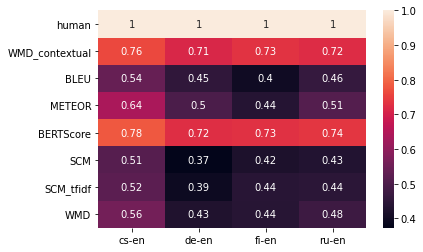

In [6]:
# Pearson
corrs_p = pd.concat([pd.DataFrame(report).corr(method="pearson").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

<AxesSubplot:>

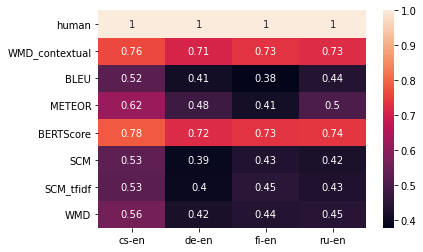

In [7]:
# Spearman
corrs_p = pd.concat([pd.DataFrame(report).corr(method="spearman").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)